## Local Additive Features Importance 

## SHAP = SHapley Additive Explanation

Method for Local feature Importance, method to find the importance of each feature on *individual predictions*.

Many models based on trees built-in global interpretation methods like *variance_inportance*. That summarize the impact of input features on the model as a whole.

TreeExplainer provides a new set of tools for understanding global model structure based on many local explanations

The inputs (trained model $f$ and single instance $x$)  pass to $\text{SHAP}$ and the output is the *explanation*. 

The explanation is the *additive* contribution of each feature, from $E[y]$ to $f(x)$. 

<!-- ### Shapley value Defined in Game Theory 

How to divide money between game players in a fair way?

Farirness properties:
- *Additivity* (Amount sum up to the final game result)
- *consistency* (mode effect - no less money)

Theorem: the only fair way to distribute the money is:

Shapey value for player *i* in game *f* = Average over all player's subsets $S \in M/\{i\}$ $[\text{Marginal distribution} \rightarrow f(S \cup i)) -f (S) ]$

Where $f$ is the game, $M$ point out all players, $S$ is a subset of players and $i$ is a specifict player.
 -->


### SHAP Values for Local Features Attributions

The SHAP Value for feature $i$ is the contribution of the feature $i$ to model prediction $f(x)$ = Average over all features's subsets $S \subset M/\{i\}$ 

Where $f$ is the training model, $M$ point out all features, $S$ subset of features, $i$ is a specific feature, $x$ is an instance to be explained.

*Naive solution*: Train the model for every subset of features. **But this don't explain our specific model**

Also, this naive solution result in exponential time.

Other problems are the missing values.


<!-- ### SHAP Algorithms

Different solutions for Runtime and Algorithm challenge

* Kernel Explainer
  * This work for all models (model agnostic)
  * Only compute the approximation since don't use all subset of features, but a *sample* of subset of features
  * Fill missing values from a background dataset. Traing dataset. K-means representative. Median of dataset. All black Image. ...

* LIME 
  * Linear model $g$ that locally approximates our model $f$ at specific point 
  * $\Epsilon = \argmin_{g \in G} L(f, g, \pi_{x'}) + \Pi(g)$

* Tree Explainer 
  * Tree-based models
  * Compute the exact values in polinomial time
  * Keep track of the tree transversal to avoid repetitions
  * weighted average of both branches if the split features is missing 

* Deep Explainer 
  * Neural Network 
  * Approximation
  * Analytically calculate SHAP values for small components. (linear layer, max polling, ...)
  * Backpropagate them using ideas from DeeoLift algorithm  -->

# An introduction to explainable AI with Shapley values

We train a linear regression model on the classic boston housing dataset. This dataset consists of 506 neighboorhood regions around Boston in 1978, where our goal is to predict the median home price (in thousands) in each neighboorhood from 14 different features:

1. CRIM - per capita crime rate by town

2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.

3. INDUS - proportion of non-retail business acres per town. 
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per $10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in $1000’s. $Q_{50}$


In [108]:
import pandas as pd
import shap
from  sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [109]:
boston = pd.read_csv(r'.\data_csv\BostonHousing.csv')

In [110]:
features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
    'ptratio', 'b', 'lstat']
target = 'medv'
# a classic housing price dataset
X, y = boston[features].copy(), boston[target].copy()

# split the data to train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [111]:
# A simple Linear Model Regression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [112]:
print("Model coefficients:\n")
for i in range(X_train.shape[1]):
    print(X_train.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

crim = -0.1246
zn = 0.0305
indus = 0.0218
chas = 2.7923
nox = -15.2135
rm = 5.2725
age = -0.0111
dis = -1.2732
rad = 0.2658
tax = -0.0115
ptratio = -0.9196
b = 0.0102
lstat = -0.3897


While coefficients are great for telling us what will happen when we change the value of an input feature, by themselves, they are not a great way to measure the overall importance of a feature. This is because the value of each coefficient depends on the scale of the input features.

If for example we were to measure the age of a home in minutes instead of years, then the coefficients for the AGE feature would become 0.0007∗365∗24∗60=367.92.

## Random Forest

The *Saabas approach* explains a prediction by following the decision path and attributing changes in the expected output of the model to each feature along the path. This is efficient since the expected value of every node in the tree can be estimated by averaging the model output over all the training samples that pass through that node. 

Let 𝑓 be a decision tree mode, 𝑥 the instance we are going to explain, 𝑓(𝑥)the output of the model for the current instance, and $𝑓_𝑥(𝑆)≈𝐸[𝑓(𝑥)∣𝑥_𝑆]$ the estimated expectation of the model output conditioned on the set 𝑆 of feature values, then we can define the Saabas value for the 𝑖’th feature as

$$ 𝜙_𝑖^𝑠(𝑓,𝑥)= ∑_{𝑗∈𝐷^𝑥_𝑖}𝑓_𝑥(𝐴_𝑗∪𝑗)−𝑓_𝑥(𝐴_𝑗)$$

where $𝐷^𝑥_𝑖$ is the set of nodes on the decision path from 𝑥 that split on feature 𝑖, and $𝐴_𝑗$ is the set of all features split on by ancestors of 𝑗. Equation 1 results in a set of feature attribution values that sum up to the difference between the expected output of the model and the output for the current prediction being explained.

When explaining an ensemble model made up of a sum of many decision trees, the Saabas values for the ensemble model are defined as the sum of the Saabas values for each tree.

Shapley values are computed by introducing each feature, one at at time, into a conditional expectation function of the model’s output, 
$𝑓_𝑥(𝑆) ≈ 𝐸[𝑓(𝑥)∣𝑥_𝑆]$ and attributing the change produced at each step to the feature that was introduced; then averaging this process over all possible feature orderings. Shapley values represent the only possible method in the broad class of additive feature attribution methods that will simultaneously satisfy three important properties: *local accuracy or Additivity*, *consistency*, and *missingness*.

* Additivity:
$$𝑓​(𝑥)=𝜙_{0}(𝑓) + ∑_{𝑖=1}^𝑀𝜙_𝑖(𝑓,𝑥)$$

We can find other the remainer properties in  https://ar5iv.labs.arxiv.org/html/1905.04610#S10

In [113]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=123)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=123)

In [114]:
# Explaining the model's predictions using SHAP values
tree_explainer = shap.TreeExplainer(rf)

# Compute the Shap values for training data
shap_values = tree_explainer(X_valid)

In [125]:
idx = 4
shap.initjs()
shap.force_plot(tree_explainer.expected_value[0], shap_values.values[idx], X_valid.iloc[[idx],:])

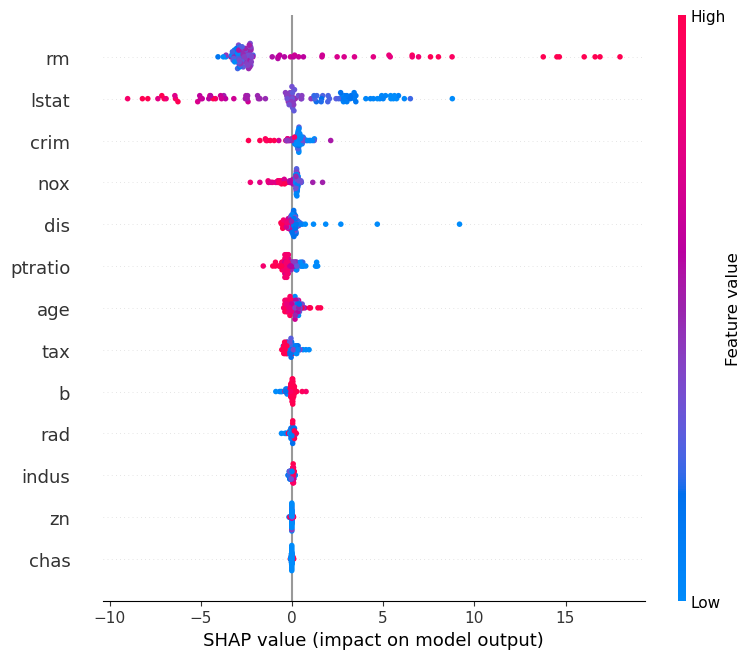

In [139]:
shap.summary_plot(shap_values, X_valid)

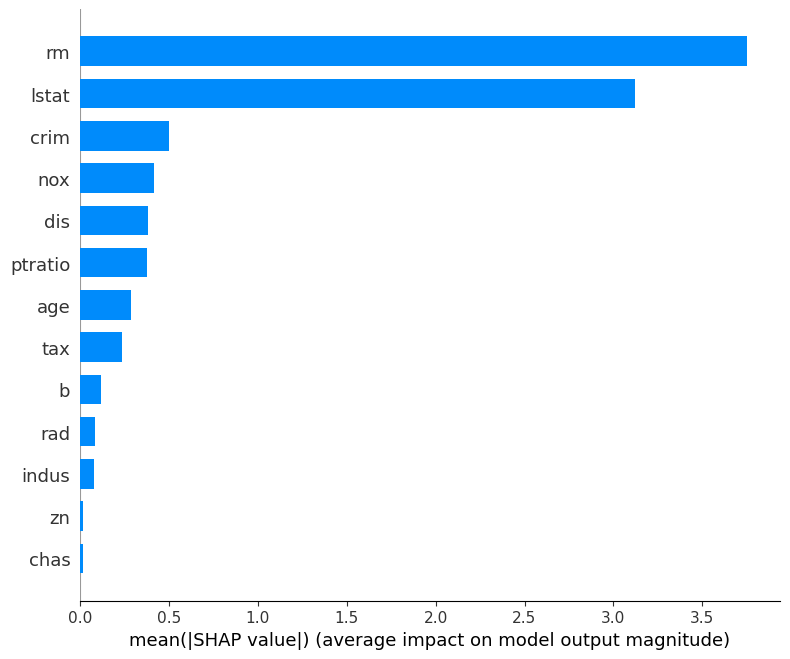

In [140]:
shap.summary_plot(shap_values, X_valid, plot_type="bar")

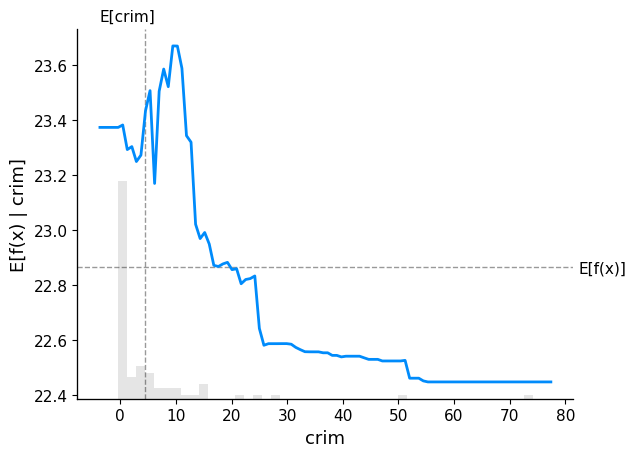

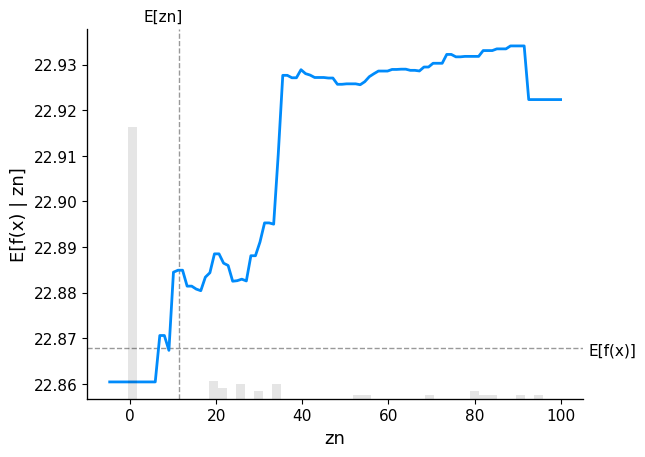

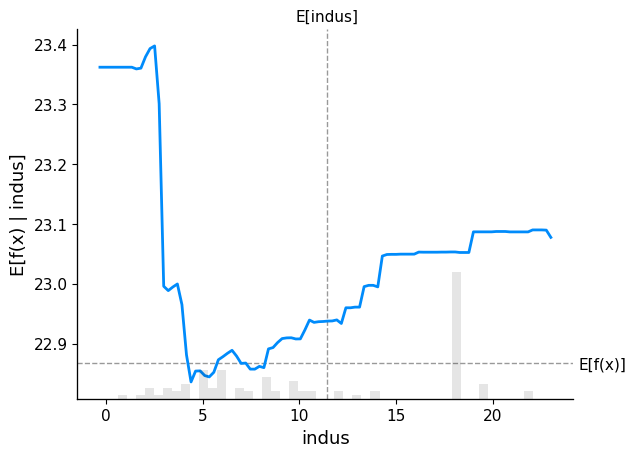

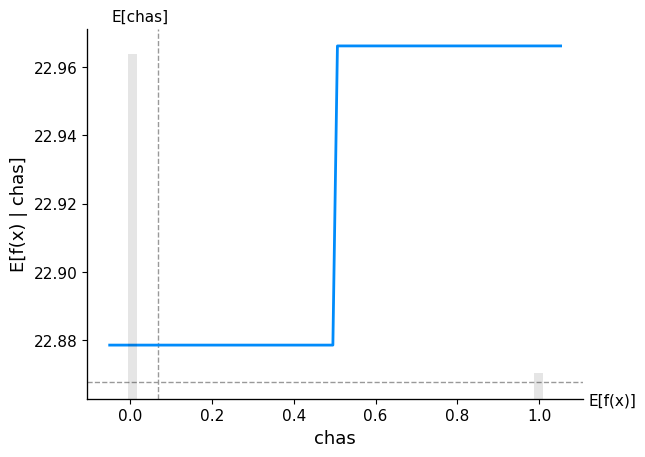

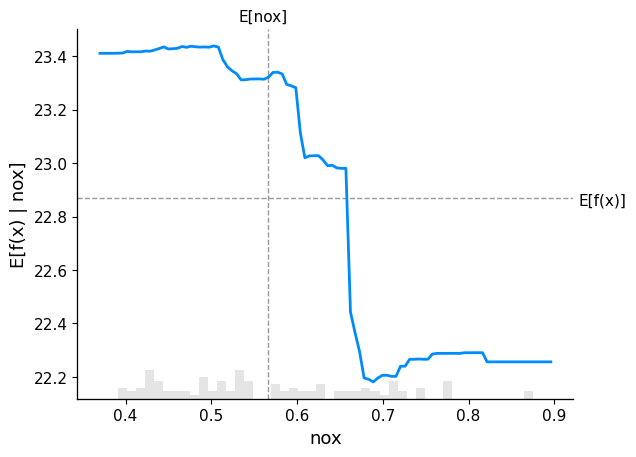

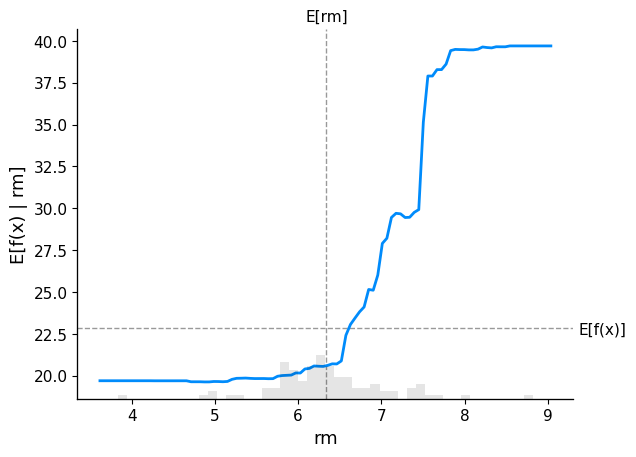

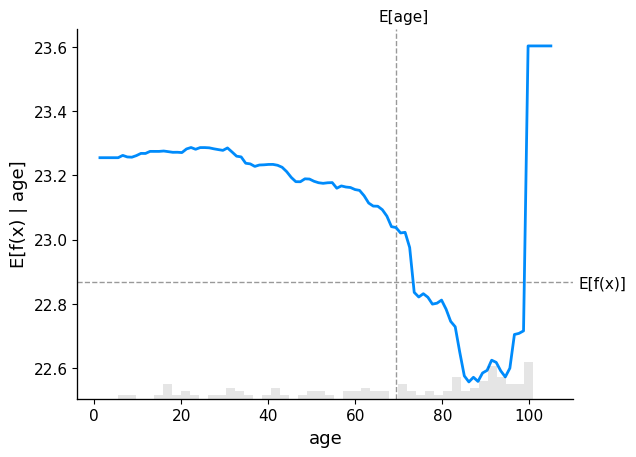

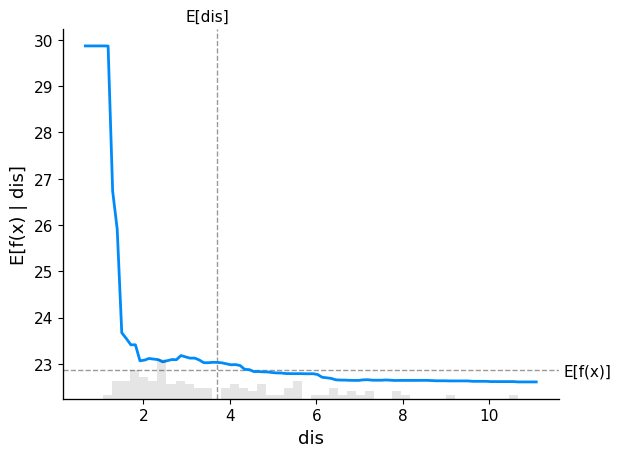

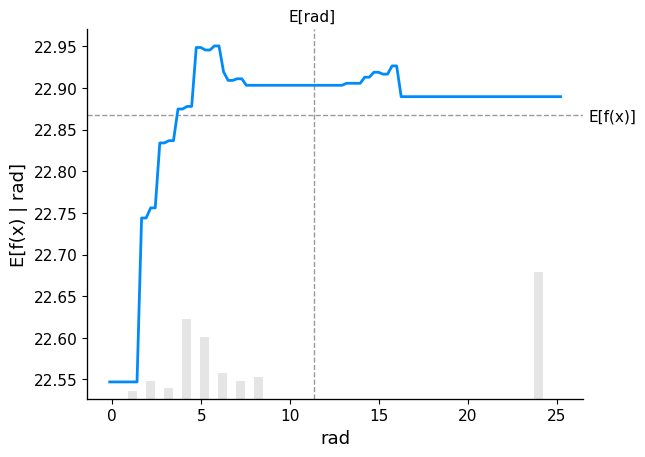

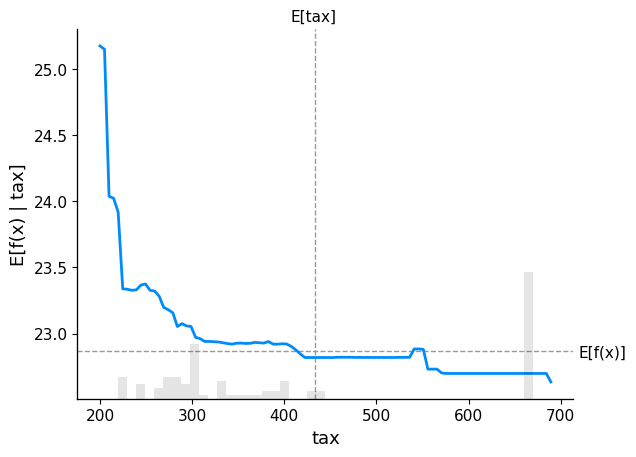

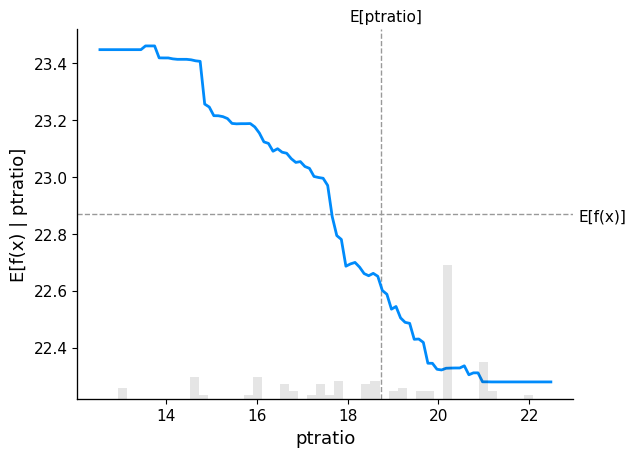

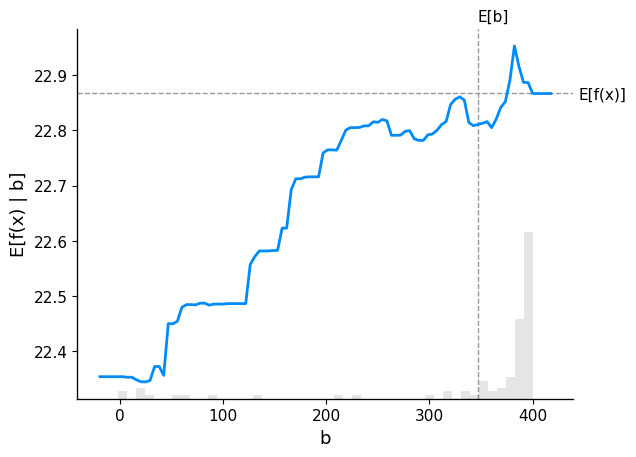

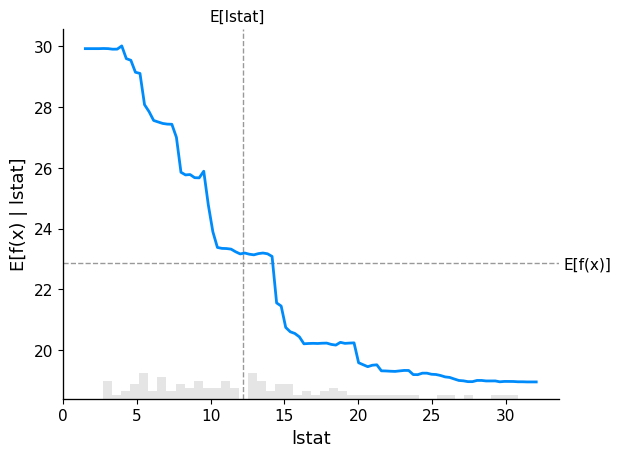

In [127]:
for column in X_valid.columns:
    shap.plots.partial_dependence(column, rf.predict, X_valid, ice=False,
    model_expected_value=True, feature_expected_value=True)

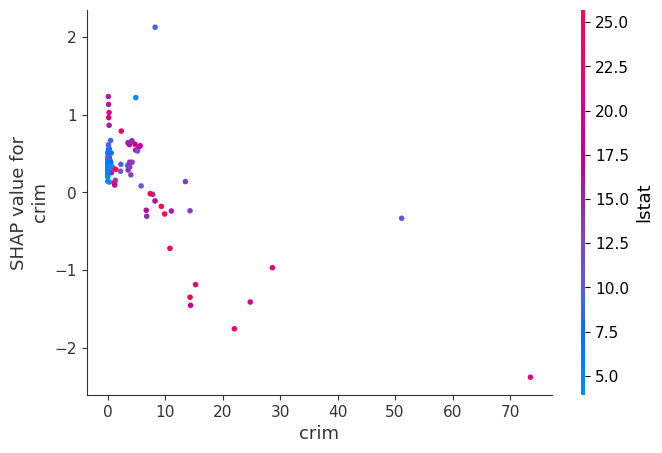

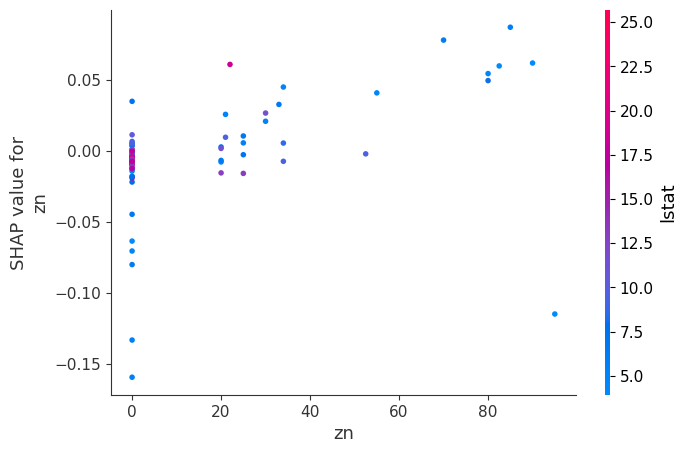

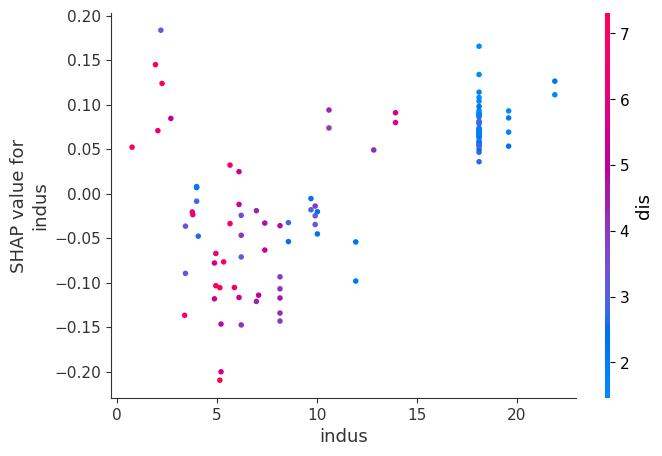

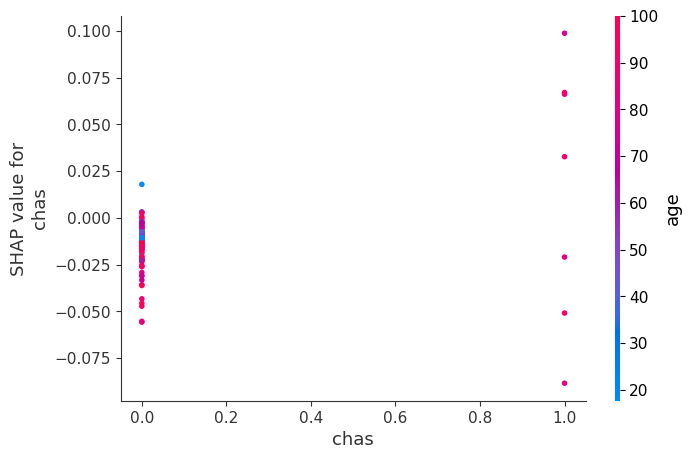

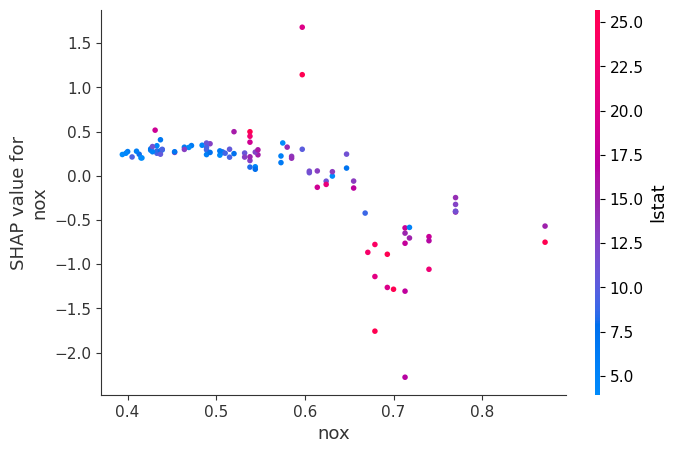

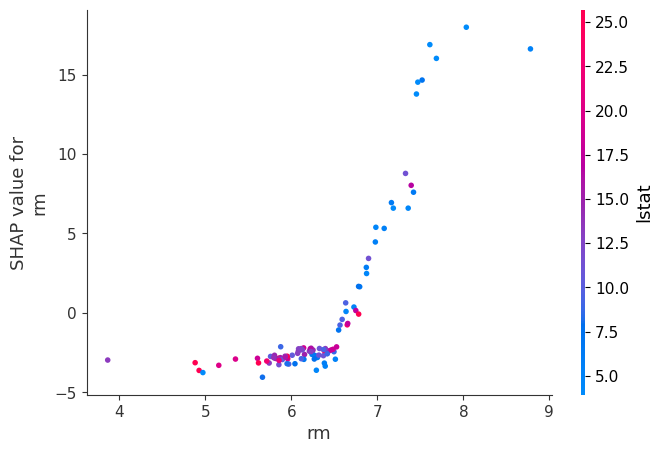

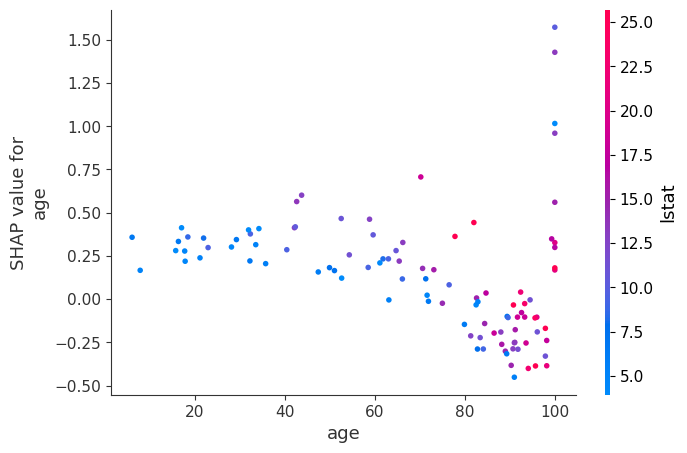

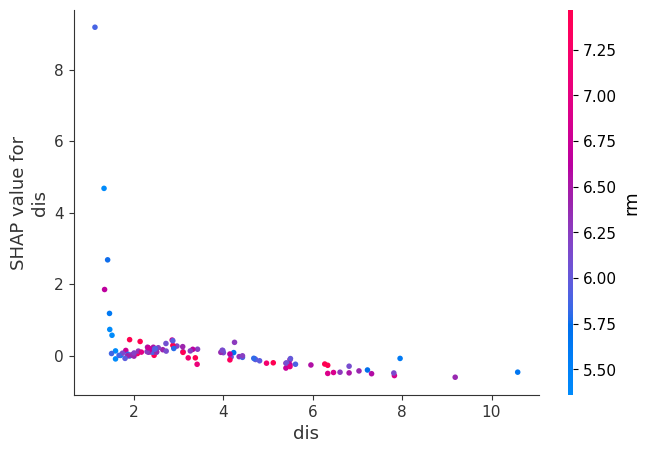

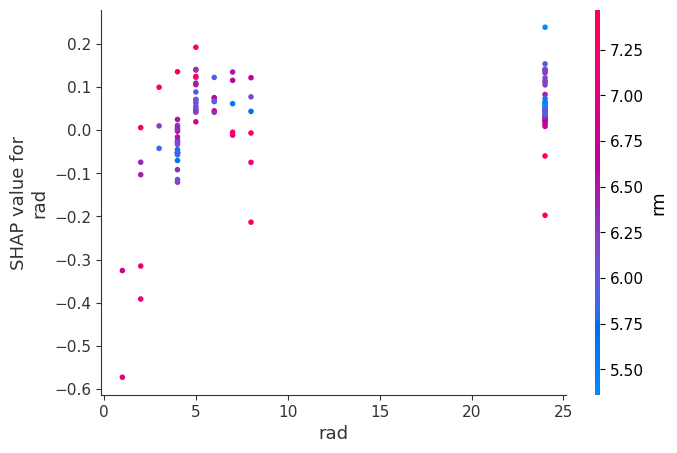

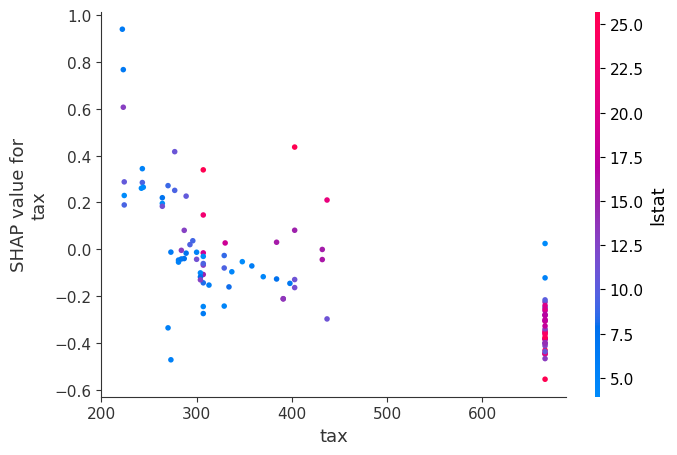

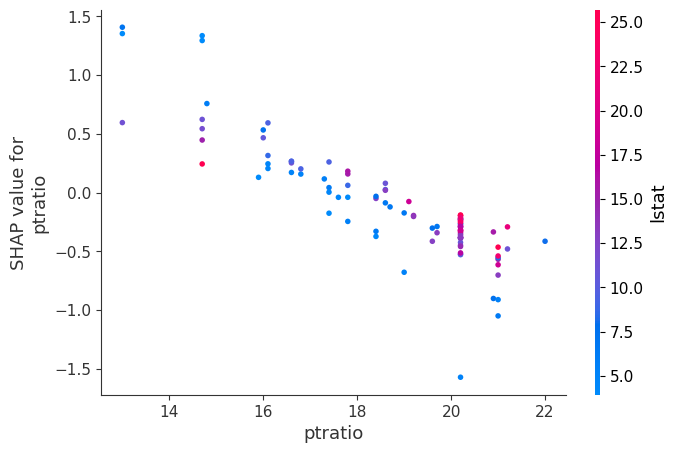

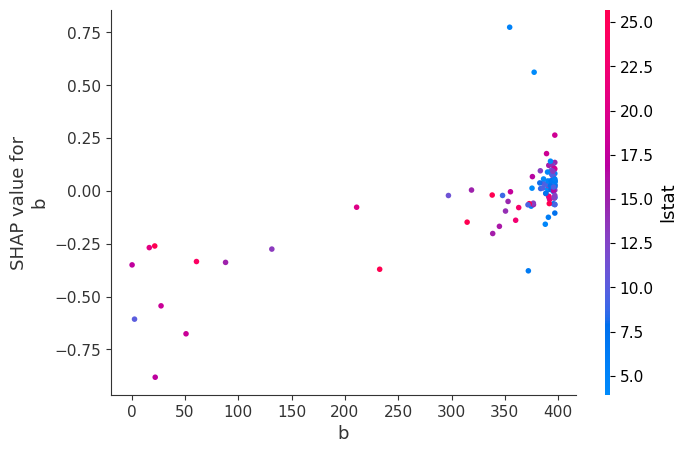

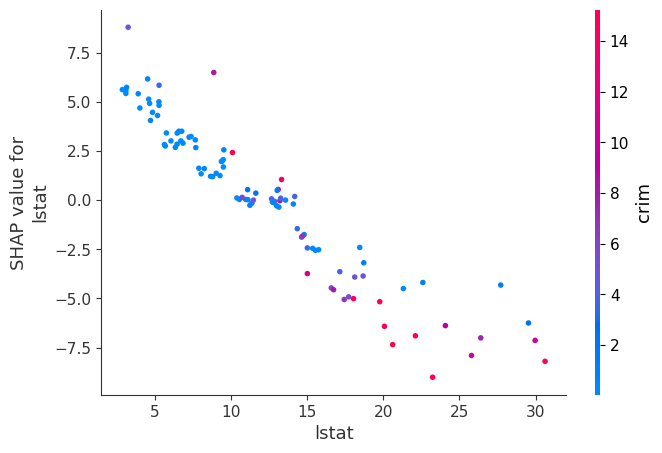

In [133]:
for column in X_valid.columns:
    shap.dependence_plot(column, shap_values.values, X_valid) # display_features=X_valid.columns

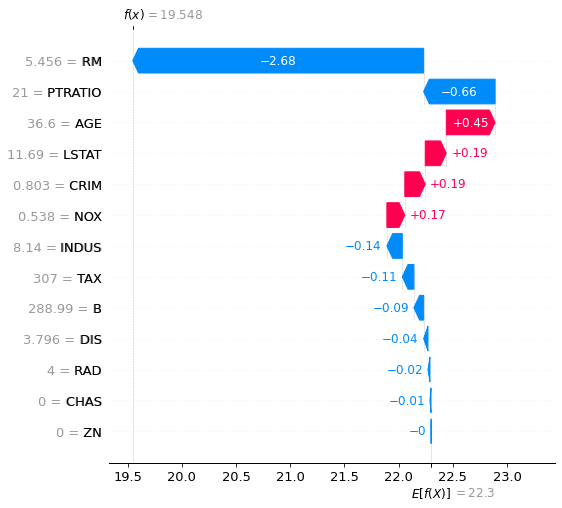

In [47]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

High values of the feature *RM* yields high positives *shap values*. That mean  High values of the feature *RM* yields $E[f(X)|X_s=x_s]>E[f(X)]$



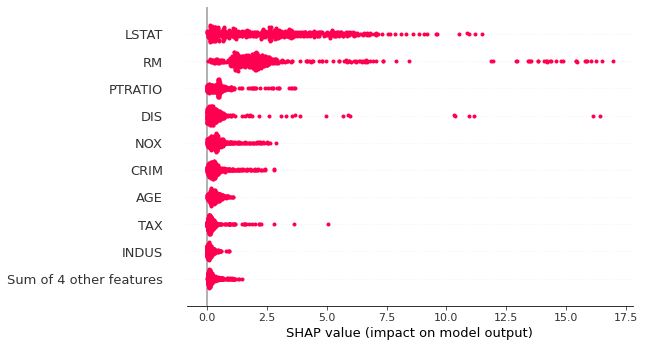

In [53]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

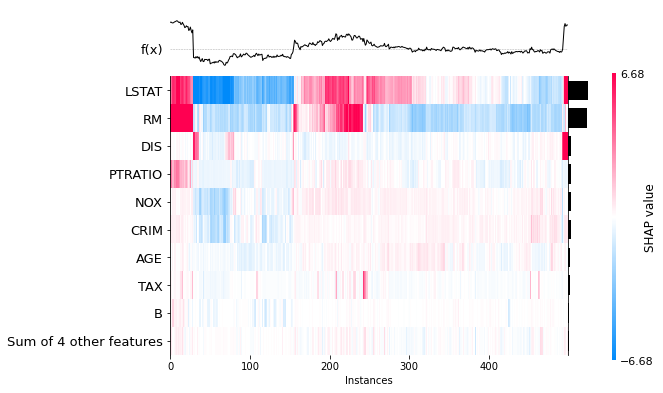

In [55]:
shap.plots.heatmap(shap_values[:1000])

## Explaining a linear logistic regression model

In [18]:
import sklearn

In [64]:
# a classic adult census dataset price dataset
X_adult, y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)

def model_adult_proba(x):
    """
    f(x) = p
    """
    return model_adult.predict_proba(x)[:,1]

def model_adult_log_odds(x):
    """
    log odd ratio = ln(p/1-p)
    """
    p = model_adult.predict_log_proba(x)
    return p[:,1] - p[:,0]

Note that explaining the probability of a linear logistic regression model is not linear in the inputs

$$Pr(G = k|X = x) = \frac{exp(β_{k0} + β_{k}^Tx)}{1 + \sum_{ℓ=1}^{K-1} exp(β_{ℓ0} + β_{ℓ}^T x)} , k = 1,..., K - 1$$

$$Pr(G = K|X = x) = \frac{1}{1 + \sum_{ℓ=1}^{K-1} exp(β_{ℓ0} + β_{ℓ}^T x)}$$


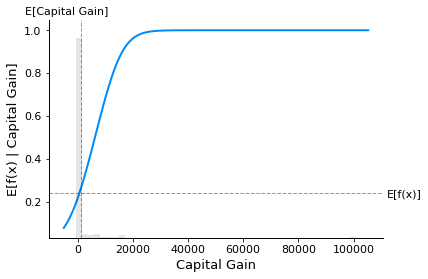

In [65]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Capital Gain", model_adult_proba, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

If we use SHAP to explain the probability of a linear logistic regression model we see strong interaction effects. This is because a linear logistic regression model NOT additive in the probability space

In [66]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)       # genere 100 samples from some dataset
explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult) # fit in order to compute shap values
                                                                            # We pass a funtion and data to fit
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])             # Compute the log odds for some observations

Permutation explainer: 1001it [00:42, 18.10it/s]                          


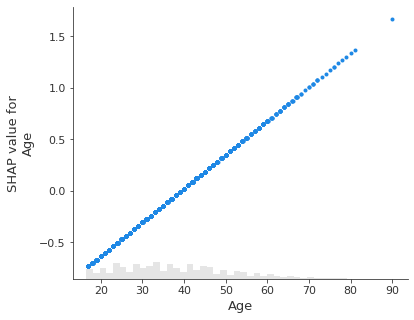

In [67]:
shap.plots.scatter(shap_values_adult_log_odds[:,"Age"])

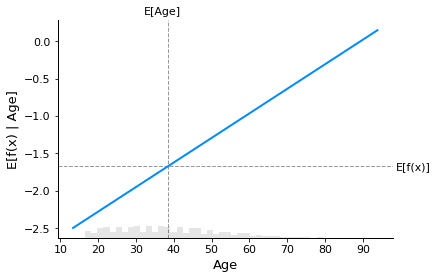

In [68]:
# make a standard partial dependence plot
sample_ind = 18
fig,ax = shap.partial_dependence_plot(
    "Age", model_adult_log_odds, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

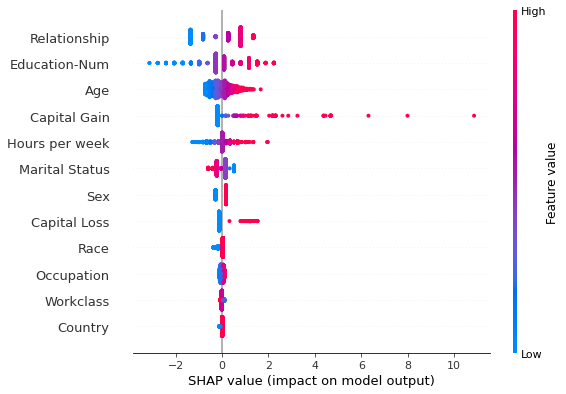

In [73]:
shap.summary_plot(shap_values_adult_log_odds)

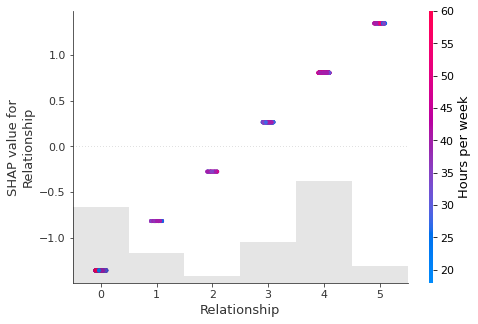

In [79]:
shap.plots.scatter(shap_values_adult_log_odds[:,"Relationship"], color=shap_values_adult_log_odds[:,'Hours per week' ])

More information:

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

## Random Forest for Classification

The algorithm that handle models based in trees like *Random Forest*, *Gradiant Boosting* or any other  is *Three Explainer*

This method compute the exact SHAP values

In [79]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

In [80]:
# Load data from Shap
X, y = shap.datasets.adult()

In [81]:
# Convert True:1 and False:0
y = np.multiply(y, 1)

# to show the impact of feature scale on KNN predictions
X.eval('Occupation = Occupation * 1000', inplace=True) 

# Select the categorical columns
categorical_columns = ['Workclass', 'Education-Num', 'Marital Status','Relationship', 'Race', 'Sex', 'Country']
 
X_categorical = X[categorical_columns].astype('str').copy()

# Convert categorical columns to dummies
X_dummies = pd.get_dummies(X_categorical)

# Select the numerical columns
X_count = X.loc[:, ~ np.isin(X.columns, categorical_columns)]

# Join the categorical columns and numerical columns
X = pd.concat([X_dummies, X_count], axis=1)

# Split the data to train and test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [153]:
rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=15, 
    random_state=123, 
    ccp_alpha=0.0008)

rf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.0008, min_samples_split=15, n_estimators=200,
                       random_state=123)

In [147]:
def print_accuracy(model, X, y, data_type = 'training'):
    accuracy = model.score(X, y)
    print('Accuracy for {} data : {:.2%}'.format(data_type, accuracy))

In [154]:
print_accuracy(rf, X_train, y_train, data_type='training')
print_accuracy(rf, X_valid, y_valid, data_type='testing')

Accuracy for training data : 85.33%
Accuracy for testing data : 85.48%


We use the `TreeExplainer` method on the model based in trees like the *Random Forest*

How to works?

- Missing values
- Categorical values -> dummies|

In [156]:
# Explaining the model's predictions using SHAP values
tree_explainer = shap.TreeExplainer(rf)

# Compute the Shap values for training data
shap_values = tree_explainer(X_train)

In [157]:
explanation = shap.Explanation(
    shap_values.values[:, :, 1],
    shap_values.base_values[:, 1],
    data = X_train,
    feature_names=X_train.columns

)

### Plot the Waterfall

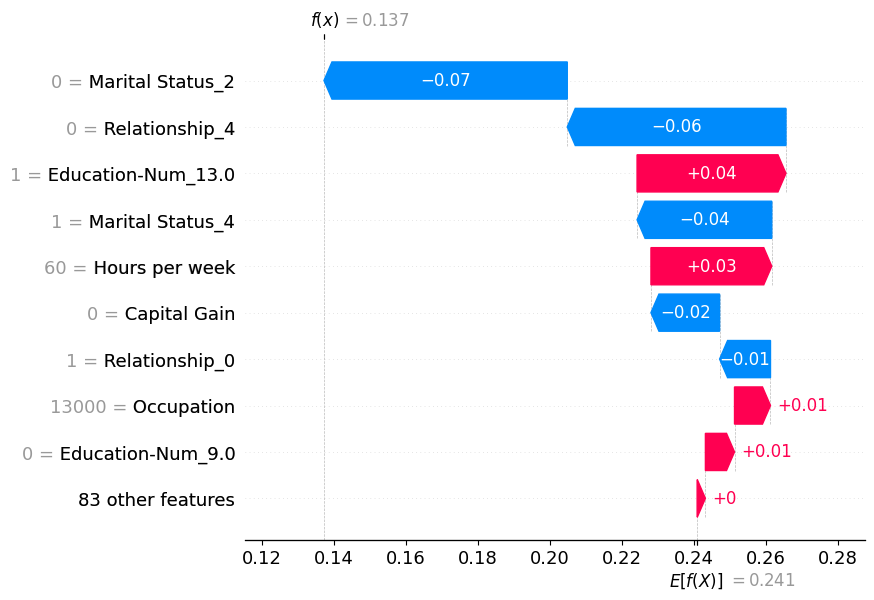

In [158]:
idx = 20
shap.plots.waterfall(explanation[idx], )

### Plot the Force Plot

In [159]:
idx = 25796
shap_values_instance = tree_explainer.shap_values(X_train.loc[[idx],:])
shap.initjs()
shap.force_plot(tree_explainer.expected_value[1], shap_values_instance[1], X_train.iloc[[idx],:])

In [176]:
shap.initjs()
shap.force_plot(explanation[:1000])

### CatBoost

https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Catboost%20tutorial.html

# Be careful when interpreting predictive models in search of causal insights

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%C2%A0insights.html

## Explaining a linear regression model

### A more complete picture using partial dependence plots

To understand a feature’s importance in a model it is necessary to understand both *how changing that feature impacts* the model’s output, and also the *distribution of that feature’s values*

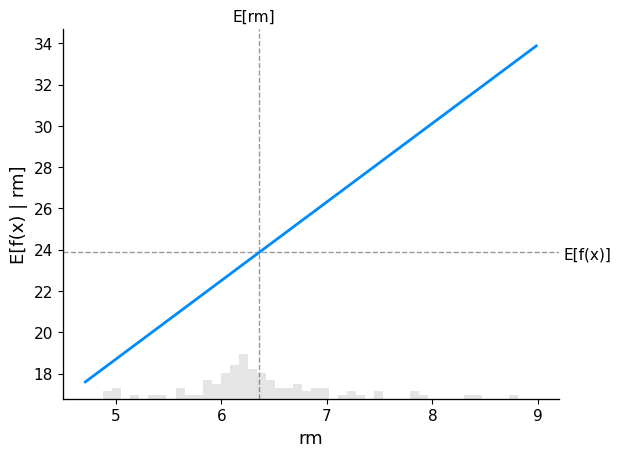

In [ ]:
# 100 instances to use as the background distribution
# These are used to compute the SHAP values
X100 = X.sample(100)

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X100)

shap.plots.partial_dependence(
    "rm", model.predict, X100, ice=False,
    model_expected_value=True, feature_expected_value=True
)

$f(x)$ is fitted from the model, in this case, a linear model, $\hat{f}(x) = \sum_{i=1}^{p}\hat{\beta}_{i}x_i$

Note that the blue partial dependence plot line (which the is average value of the model output when we fix the RM feature to a given value) always passes through the interesection of the two gray expected value lines.

We can consider this intersection point as the “center” of the partial dependence plot with respect to the data distribution

Since $E[f(x)]$ and $E[RM]$ are independent and also $E[f(x)]$ is a paramenter, $E[E[f(x)]|E[RM]] = E[f(x)] $

The core idea behind Shapley value based explanations of machine learning models is to use `fair allocation` results from cooperative game theory to allocate credit for a model’s output $f(x)$ among its input features.

In order to connect game theory with machine learning models it is nessesary to both match *a model’s input features with players* in a game, and also match the *model function with the rules of the game*.

A player can belong to game or not. So, a feature can be include into model or not.

To evaluate an existing model $f$ when only a subset $S$ of features are part of the model we integrate out the other features using a conditional expectated value formulation:

$$E[f(x)|X_s = x_s]$$

Computing the SHAP values to linear model

When we are explaining a prediction $f(x)$ , the SHAP value for a specific feature $i$ is just the difference between the expected model output and the partial dependence plot at the feature’s value $x_i$: 

$$E[f_{S \cup i }(x)] - E[f_{S}(x)] = \text{shap value}$$ 

Permutation explainer: 507it [00:23, 11.53it/s]                         


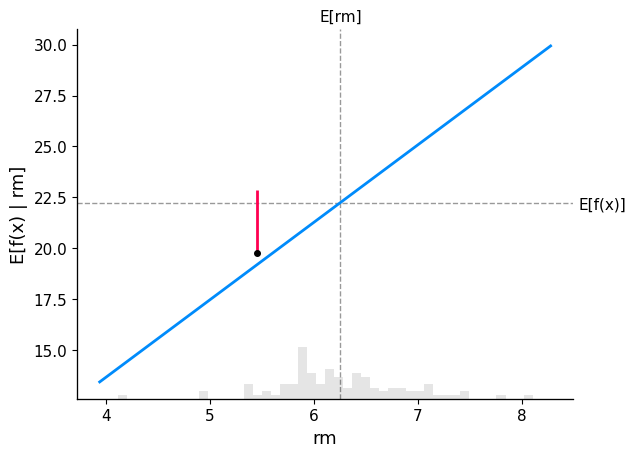

In [ ]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 18
shap.partial_dependence_plot(
    "rm", model.predict, X100, 
    model_expected_value=True,
    feature_expected_value=True, 
    ice=False,
    shap_values=shap_values[sample_ind:sample_ind+1,:]
)

If we plot the SHAP value for a specific feature across a whole dataset we will exactly trace out a mean centered version of the partial dependence plot for that feature:

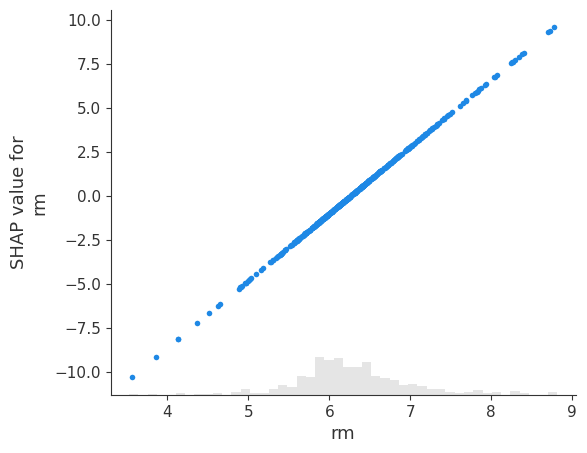

In [ ]:
shap.plots.scatter(shap_values[:,"rm"])

One the fundemental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. 

For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained.

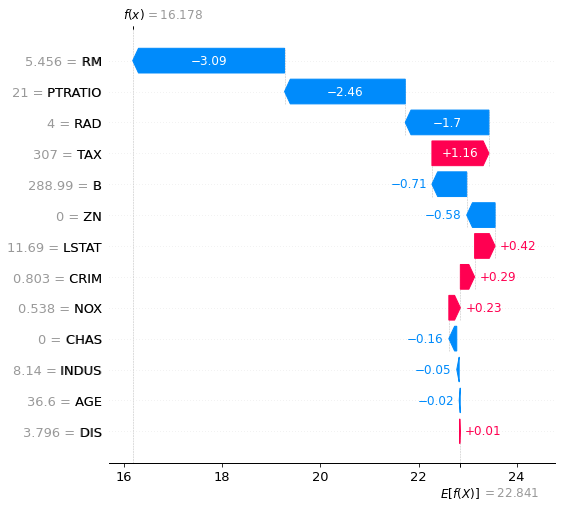

In [ ]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)